In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

import numpy as np
import pickle
from sort_src.sort import SORT
from sort_src.fold_utils import get_all_metrics, plot_structure, filter_dbr_by_dist, get_coords
from sort_src.sort_utils import random_mask
from sort_src.pydscatter import dscatter_plot
from scipy.stats import pearsonr, mannwhitneyu
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
from cmap import Colormap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from scipy.cluster.hierarchy import linkage, fcluster
import mavenn

## Table S1

In [3]:
# load Sort-seq data
sorts = {}

sorts['5ss']     = SORT('../config/sortseq_csvs/5ss.csv', '../config/fasta_files/5ss.fasta')
sorts['5ss'].load_flow_data()
sorts['5ss_HA']  = SORT('../config/sortseq_csvs/5ss_HA.csv', '../config/fasta_files/5ss_HA_MYC.fasta')
sorts['5ss_HA'].load_flow_data()
sorts['5ss_MYC'] = SORT('../config/sortseq_csvs/5ss_MYC.csv', '../config/fasta_files/5ss_HA_MYC.fasta')
sorts['5ss_MYC'].load_flow_data()
sorts['3ss']     = SORT('../config/sortseq_csvs/3ss.csv', '../config/fasta_files/3ss.fasta')
sorts['3ss'].load_flow_data()
sorts['bs']      = SORT('../config/sortseq_csvs/bs.csv', '../config/fasta_files/bs.fasta')
sorts['bs'].load_flow_data()

# load Sort-seq data
sorts['wsl'] = SORT('../config/sortseq_csvs/walking_stem.csv', '../config/fasta_files/walking_stem.fasta')
sorts['wsl'].load_flow_data()

# load Sort-seq element from configuration csv specifying all file paths
sorts['ran'] = SORT('../config/sortseq_csvs/random.csv', '../config/fasta_files/random_lib_clust.fasta')
sorts['ran'].load_flow_data(plot=False)

# in this case, adding additional Sort-seq bins that were sorted separately (needed because they have different control measurements)
sorts['ran'].add_sort_data('../data/fcs/random/random_bin15.fcs', 
                  '../data/fcs/random/random_wt_pos_bin15_bin16.fcs',
                  '../data/fcs/random/random_wt_neg_bin15_bin16.fcs', 
                  '../data/counts/random_bin15_counts.pkl', 
                  'bin_15')

sorts['ran'].add_sort_data('../data/fcs/random/random_bin16.fcs', 
                  '../data/fcs/random/random_wt_pos_bin15_bin16.fcs',
                  '../data/fcs/random/random_wt_neg_bin15_bin16.fcs', 
                  '../data/counts/random_bin16_counts.pkl', 
                  'bin_16')

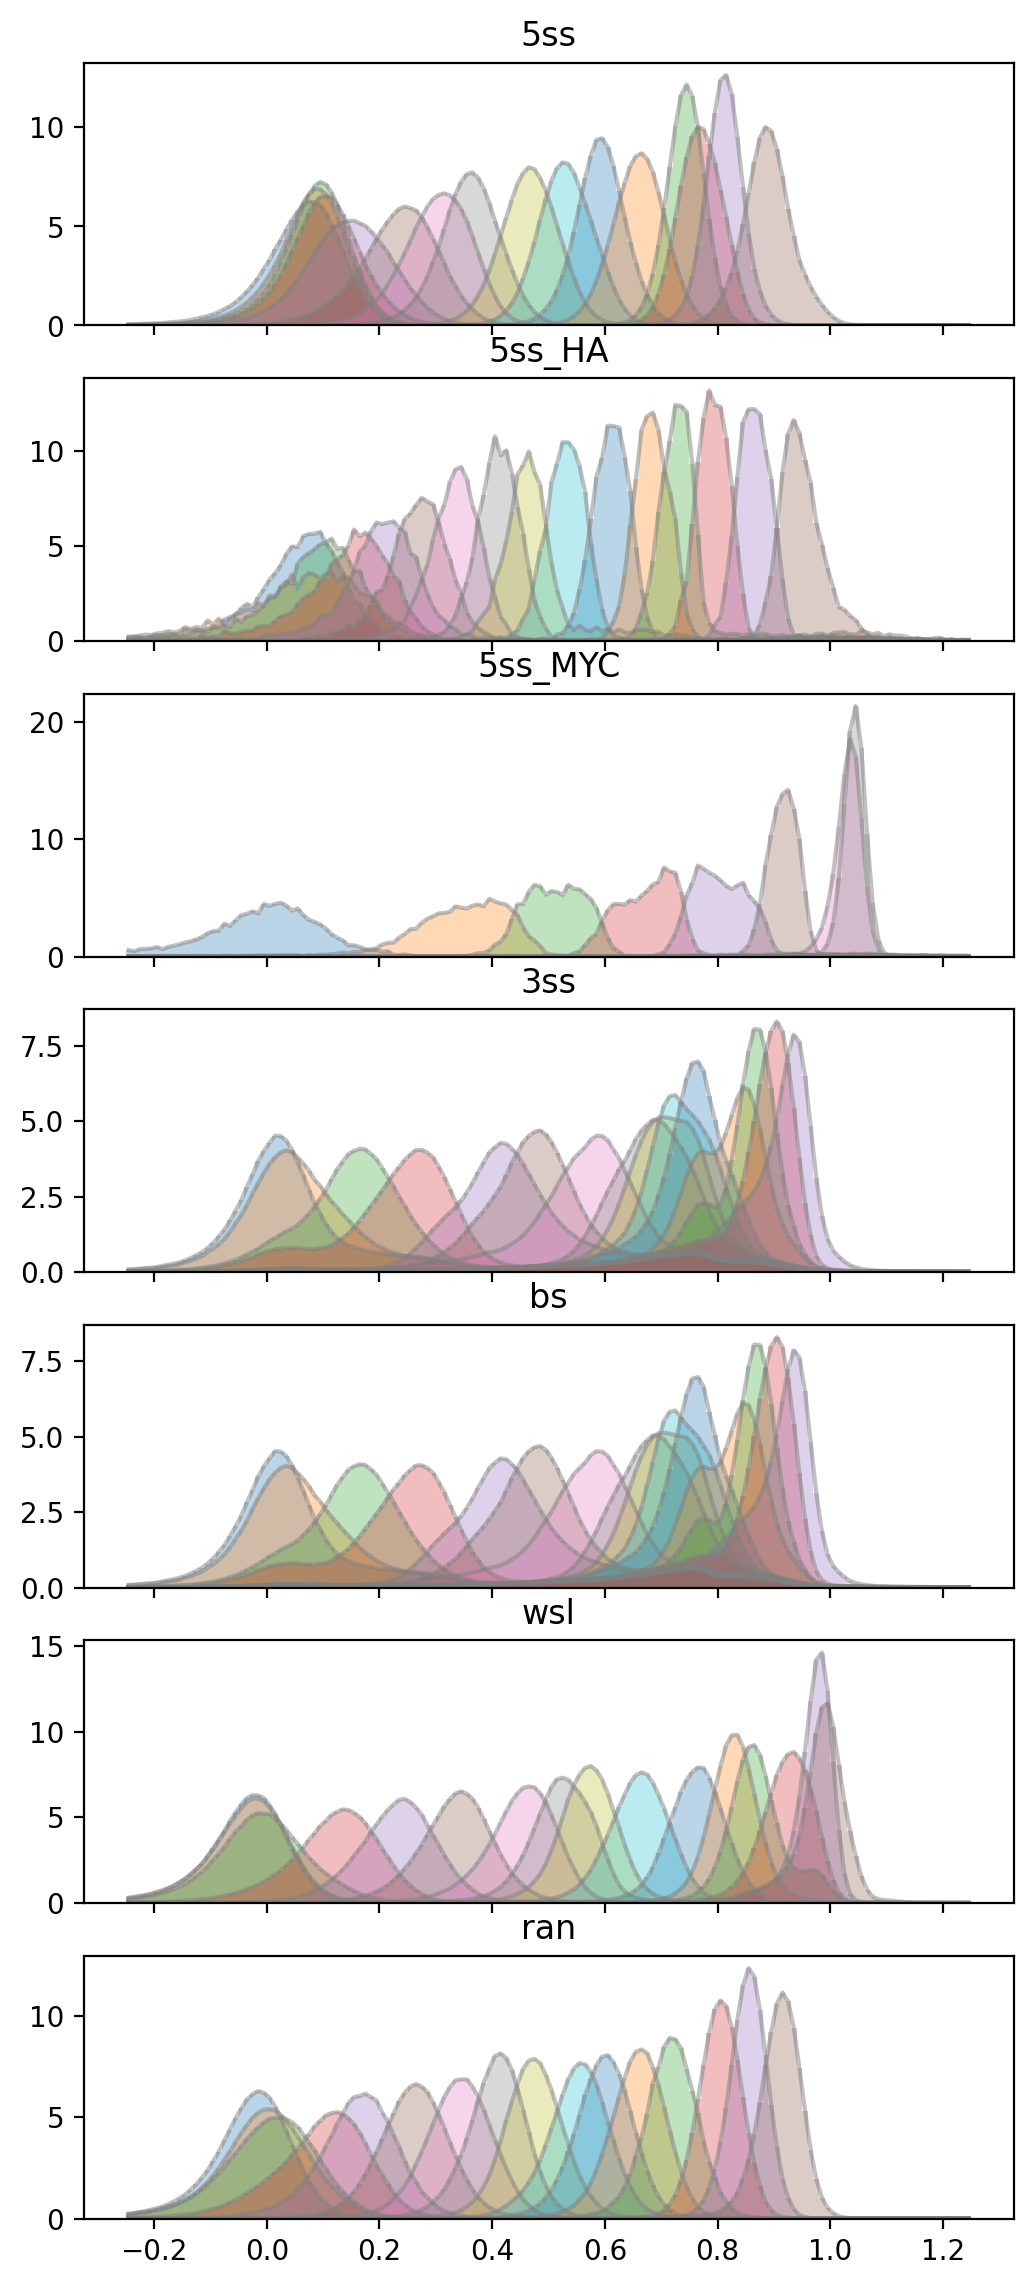

In [4]:
# plot individual bin distributions
fig, axs = plt.subplots(len(sorts), 1, figsize=[6, 2*len(sorts)], sharex=True)
for i, ds in enumerate(sorts.keys()):
    sorts[ds].plot_hists(axs[i])
    axs[i].set_title(ds)
plt.show()

## Figure S3a, c

In [5]:
# load Sort-seq data
sorts = {}

sorts['5ss']     = SORT('../config/sortseq_csvs/5ss.csv', '../config/fasta_files/5ss.fasta')
sorts['5ss'].load_flow_data()
sorts['5ss_HA']  = SORT('../config/sortseq_csvs/5ss_HA.csv', '../config/fasta_files/5ss_HA_MYC.fasta')
sorts['5ss_HA'].load_flow_data()
sorts['5ss_MYC'] = SORT('../config/sortseq_csvs/5ss_MYC.csv', '../config/fasta_files/5ss_HA_MYC.fasta')
sorts['5ss_MYC'].load_flow_data()
sorts['3ss']     = SORT('../config/sortseq_csvs/3ss.csv', '../config/fasta_files/3ss.fasta')
sorts['3ss'].load_flow_data()
sorts['bs']      = SORT('../config/sortseq_csvs/bs.csv', '../config/fasta_files/bs.fasta')
sorts['bs'].load_flow_data()

sorts['5ss'].load_seq_data(min_reads=10, cutoff=0.5, n_cpu=8)
sorts['5ss_HA'].load_seq_data(min_reads=10, cutoff=0.5, n_cpu=8)
sorts['5ss_MYC'].load_seq_data(min_reads=10, cutoff=0.5, n_cpu=8)
sorts['3ss'].load_seq_data(min_reads=10, cutoff=1.4, n_cpu=8)
sorts['bs'].load_seq_data(min_reads=10, cutoff=0.4, n_cpu=8)

/Users/leo/Documents/repos/intron_sortseq/sort_src/sort_utils.py:19: RuntimeWarning: invalid value encountered in divide
  sort_mat_scaled = sort_mat_scaled/np.sum(sort_mat_scaled, axis=1)[:,None]


This script performs structure prediction for different sequence windows, and then trains a random forest to predict gene output from pairing probabilities. The purpose is to find the optimal structure prediction window. This takes a long time, so the results are provided below.

```python
import numpy as np
import pickle
import dill
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sort_src.fold_utils import get_all_metrics
from scipy.stats import pearsonr
import random
from tqdm import tqdm
from itertools import product, islice

def random_mask(n, frac, seed=42):
    random.seed(seed)
    n_true = round(frac*n)
    msk = [True]*n_true + [False]*(n-n_true)
    random.shuffle(msk)
    return(np.array(msk))

def run():

    # load SORTseq object

    # uncomment the one you're running, path might have to be adjusted depending on where the script is executed
    sort = SORT('../config/sortseq_csvs/5ss.csv', '../config/fasta_files/5ss.fasta')
    sort.load_flow_data()
    sort.load_seq_data(min_reads=10, cutoff=0.5, n_cpu=8)

    # sort = SORT('../config/sortseq_csvs/3ss.csv', '../config/fasta_files/3ss.fasta')
    # sort.load_flow_data()
    # sort.load_seq_data(min_reads=10, cutoff=1.4, n_cpu=8)

    # sort = SORT('../config/sortseq_csvs/bs.csv', '../config/fasta_files/bs.fasta')
    # sort.load_flow_data()
    # sort.load_seq_data(min_reads=10, cutoff=0.4, n_cpu=8)

    e1 = 'UUAGUUUCGAAUAAACACACAUAAACAAACAAAUCUAGAAUGUACCCAUACGAUGUUCCUGACUAUGCUGGUUCUGCAG'
    e2 = 'GUGUCUCUAAGGGUGAAGAAGAUAACAUGGCUUCUUUGCCAGCCACCCACGAGUUGCACAUCUUCGGUUCCAUUAACGG'

    # rfr scan
    y = np.array(sort.sort_df['mu_est'])
    s = np.array(sort.sort_df['index'])

    ####################################################
    n_cpu = 64
    step_size = 1
    e1_dist = np.arange(1, len(e1) + step_size, step_size)
    step_size = 2
    i1_dist = np.arange(1, len(s[0]+e2) + step_size, step_size)
    ####################################################

    score_mat = np.zeros((len(e1_dist), len(i1_dist)))
    corr_mat = np.zeros((len(e1_dist), len(i1_dist)))
    start_index = 6689 #3981 #6000 #2953 #1683
    total = len(e1_dist) * len(i1_dist)
    for i, j in tqdm(islice(product(np.arange(len(e1_dist)), np.arange(len(i1_dist))), start_index, None), total=total - start_index):

        # structure prediction
        pred_seqs = [e1[-e1_dist[i]:] + (intron+e2)[:i1_dist[j]] for intron in s]
        bpp, dbr_mea, mea, dbr_mfe, mfe, dbr_efe, efe, p_mfe, ent, ed = get_all_metrics(pred_seqs, n_cpu=n_cpu)

        # test how good the forest is
        ra_msk = random_mask(len(y), 0.85)
        rfr = RandomForestRegressor(n_estimators=200, max_features=0.3, random_state=42, n_jobs=n_cpu)
        rfr.fit(bpp[ra_msk], y[ra_msk])
        score = r2_score(y[~ra_msk], rfr.predict(bpp[~ra_msk]))
        corr  = pearsonr(efe, y).statistic

        score_mat[i, j] = score
        corr_mat[i, j]  = corr

        with open('../data/miscellaneous/rfr_scan_5ss.pkl', 'wb') as f:
            pickle.dump((score_mat, corr_mat), f)

if __name__ == "__main__":

    run()

```

In [6]:
# structure scan params
e1 = 'UUAGUUUCGAAUAAACACACAUAAACAAACAAAUCUAGAAUGUACCCAUACGAUGUUCCUGACUAUGCUGGUUCUGCAG'
e2 = 'GUGUCUCUAAGGGUGAAGAAGAUAACAUGGCUUCUUUGCCAGCCACCCACGAGUUGCACAUCUUCGGUUCCAUUAACGG'
step_size = 1
e1_dist = np.arange(1, len(e1) + step_size, step_size)
step_size = 2

# load results
with open('../data/miscellaneous/rfr_scan_5ss.pkl', 'rb') as f:
    score_mat_ss5, corr_mat_ss5 = pickle.load(f)
with open('../data/miscellaneous/rfr_scan_3ss.pkl', 'rb') as f:
    score_mat_ss3, corr_mat_ss3 = pickle.load(f)
with open('../data/miscellaneous/rfr_scan_bs.pkl', 'rb') as f:
    score_mat_branch, corr_mat_branch = pickle.load(f)

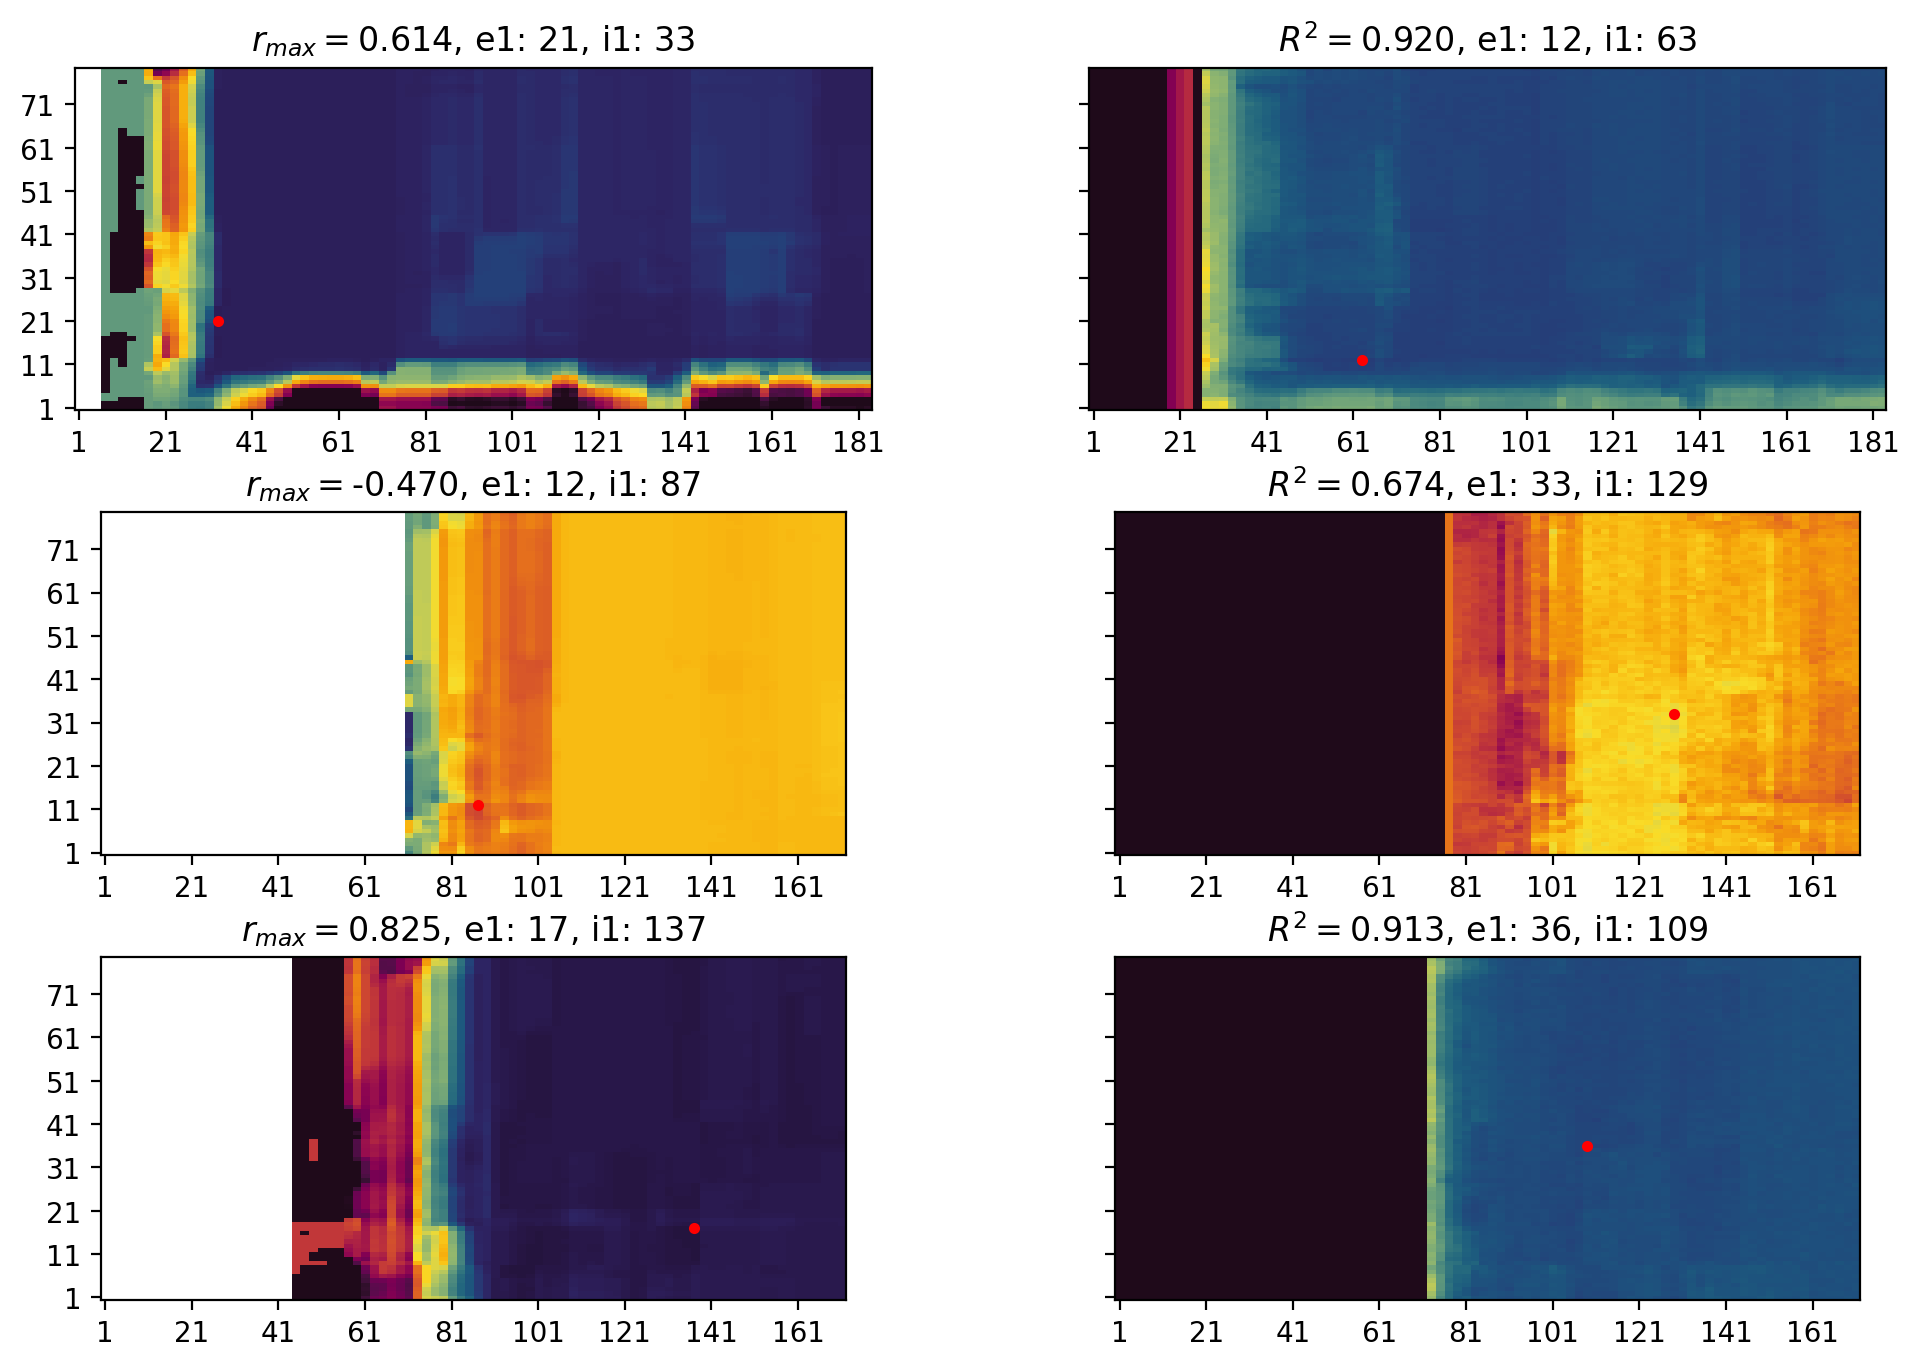

In [7]:
fig, axs = plt.subplots(3, 2, figsize=[12, 8], sharey=True)
plt.subplots_adjust(hspace=0.3)
pride = Colormap('pride_r').to_mpl()

w_opt = [[], [], []]
lims = [(0, 0.65), (-0.65, 0), (0, 0.85)]
for idx, (sort_id, corr_mat, score_mat) in enumerate(zip(['5ss', '3ss', 'bs'], 
                                                         [corr_mat_ss5, corr_mat_ss3, corr_mat_branch], 
                                                         [score_mat_ss5, score_mat_ss3, score_mat_branch])):
    
    i1_dist = np.arange(1, len(sorts[sort_id].sort_df['index'][0]+e2) + step_size, step_size)
    
    axs[idx, 0].imshow(corr_mat, vmin=lims[idx][0], vmax=lims[idx][1], cmap=pride, origin='lower', aspect=0.5)
    best_pos = np.unravel_index(np.nanargmax(np.abs(corr_mat)), corr_mat.shape)
    w_opt[idx].append((e1_dist[best_pos[0]], i1_dist[best_pos[1]]))
    axs[idx, 0].plot(best_pos[1], best_pos[0], '.r')
    axs[idx, 0].set_title(f"$r_{{max}}=${corr_mat[best_pos]:.3f}, e1: {e1_dist[best_pos[0]]}, i1: {i1_dist[best_pos[1]]}")
    axs[idx, 0].set_yticks(np.arange(0, corr_mat.shape[0], 10), [e1_dist[i] for i in np.arange(0, corr_mat.shape[0], 10)])
    axs[idx, 0].set_xticks(np.arange(0, corr_mat.shape[1], 10), [i1_dist[i] for i in np.arange(0, corr_mat.shape[1], 10)])

    axs[idx, 1].imshow(score_mat, vmin=0.3, vmax=1, cmap=pride, origin='lower', aspect=0.5)
    best_pos = np.unravel_index(np.nanargmax(score_mat), score_mat.shape)
    w_opt[idx].append((e1_dist[best_pos[0]], i1_dist[best_pos[1]]))
    axs[idx, 1].plot(best_pos[1], best_pos[0], '.r')
    axs[idx, 1].set_title(f"$R^{{2}}=${score_mat[best_pos]:.3f}, e1: {e1_dist[best_pos[0]]}, i1: {i1_dist[best_pos[1]]}")
    axs[idx, 1].set_yticks(np.arange(0, corr_mat.shape[0], 10), [e1_dist[i] for i in np.arange(0, corr_mat.shape[0], 10)])
    axs[idx, 1].set_xticks(np.arange(0, corr_mat.shape[1], 10), [i1_dist[i] for i in np.arange(0, corr_mat.shape[1], 10)])
    
# axs.set_xlabel('intron_dist')
# axs.set_ylabel('exon_dist')

plt.show()

In [8]:
# re-train forests on optimal windows with cross-validation

def predict_and_train(sort, e1, e_dist, i_dist, n_cpu=8):
    # structure prediction
    pred_seqs = [e1[-e_dist:] + (intron+e2)[:i_dist] for intron in list(sort.sort_df['index'])]
    bpp, dbr_mea, mea, dbr_mfe, mfe, dbr_efe, efe, p_mfe, ent, ed = get_all_metrics(pred_seqs, n_cpu=n_cpu)

    y = sort.sort_df.get_column('mu_est').to_numpy()

    # test how good the forest is
    ra_msk = random_mask(len(y), 0.85)
    rfr = RandomForestRegressor(n_estimators=200, max_features=0.3, random_state=42, n_jobs=n_cpu)
    rfr.fit(bpp[ra_msk], y[ra_msk])

    # evaluate performance
    scores_r2 = cross_val_score(rfr, bpp, y, cv=KFold(30, shuffle=True), scoring='r2', n_jobs=n_cpu)

    # evaluate feature importance
    importance = permutation_importance(rfr, bpp[~ra_msk], y[~ra_msk], n_repeats=30, random_state=42, n_jobs=n_cpu)

    return(rfr, scores_r2, importance, ra_msk, bpp, efe, dbr_mfe, pred_seqs)

In [9]:
# This will take some time; ~5min on 8 Apple Silicon cores.
rfr_s5, scores_r2_s5, importance_s5, ra_msk_s5, bpp_s5, efe_s5, dbr_s5, p_seqs_s5 = predict_and_train(sorts['5ss'], e1, w_opt[0][1][0], w_opt[0][1][1])
rfr_s3, scores_r2_s3, importance_s3, ra_msk_s3, bpp_s3, efe_s3, dbr_s3, p_seqs_s3 = predict_and_train(sorts['3ss'], e1, w_opt[1][1][0], w_opt[1][1][1])
rfr_bs, scores_r2_bs, importance_bs, ra_msk_bs, bpp_bs, efe_bs, dbr_bs, p_seqs_bs = predict_and_train(sorts['bs'], e1,  w_opt[2][1][0], w_opt[2][1][1])

/opt/homebrew/anaconda3/envs/sort_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## Figure 4b

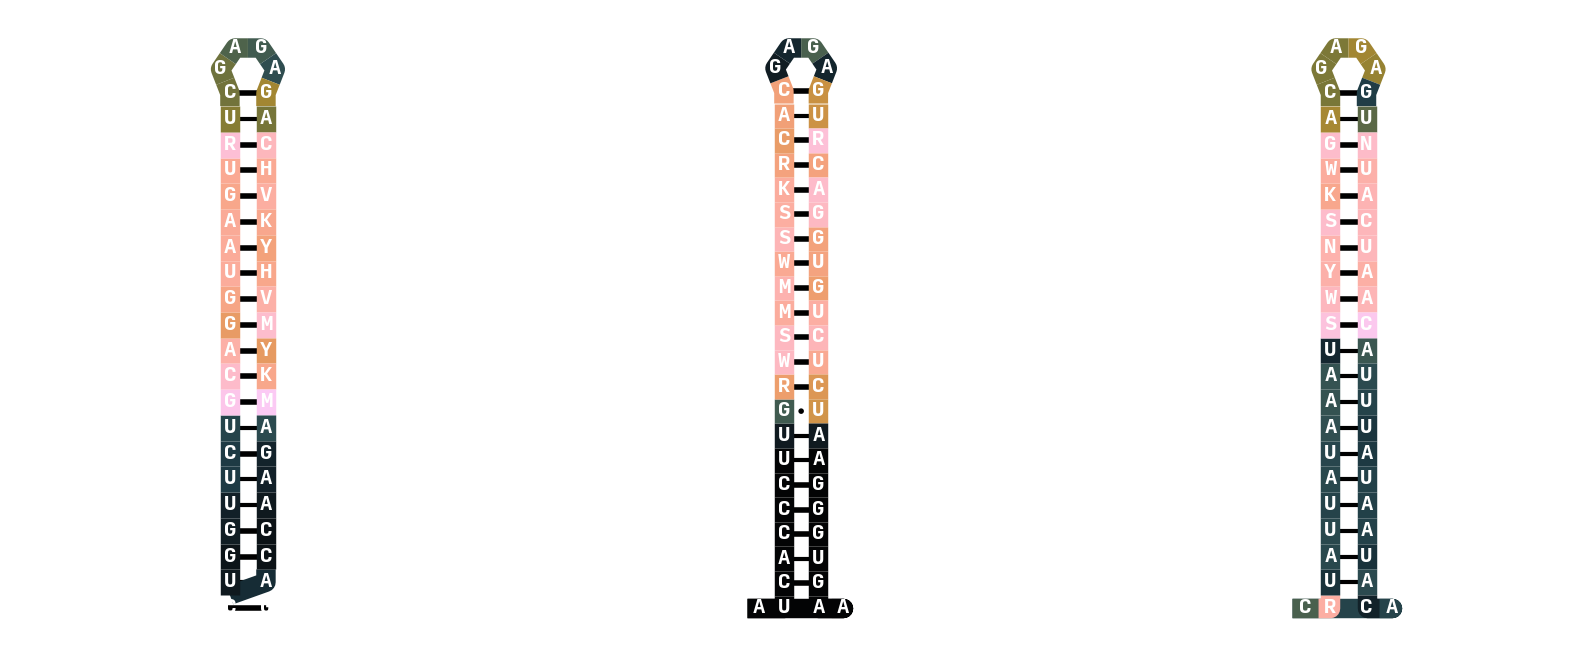

In [10]:

# plot structures

dbr_s5p = '(((((((((((((((((((((....)))))))))))))))))))))'
seq_s5p = 'CUGGUUCUGCAGGUAAGURUCGAGAGACHVKYHVMYKMAGAACCAG'
dbr_s3p = '..((((((((((((((((((((((....))))))))))))))))))))))..'
seq_s3p = 'UAUCACCCUUGRWSMMWSSKRCACGAGAGURCAGGUGUCUCUAAGGGUGAAG'
dbr_bsp = '..(((((((((((((((((((((....)))))))))))))))))))))..'
seq_bsp = 'ACRUAUUAUAAAUSWYNSKWGACGAGAGUNUACUAACAUUUAUAAUACAG'

fig, axs = plt.subplots(1, 3, figsize=[10, 4])
cmap_f = Colormap('batlowk').to_mpl()
plot_structure(seq_s5p, dbr_s5p, np.std(bpp_s5, axis=0)[0:46], np.ones(len(seq_s5p), dtype=bool), axs=axs[0], cmap=cmap_f, vmin=0, vmax=0.5, line_width=7)
plot_structure(seq_s3p, dbr_s3p, np.std(bpp_s3, axis=0)[91:143], np.ones(len(seq_s3p), dtype=bool), axs=axs[1], cmap=cmap_f, vmin=0, vmax=0.5, line_width=7)
plot_structure(seq_bsp, dbr_bsp, np.std(bpp_bs, axis=0)[78:128], np.ones(len(seq_bsp), dtype=bool), axs=axs[2], cmap=cmap_f, vmin=0, vmax=0.5, line_width=7)

plt.show()

## Figure 4c

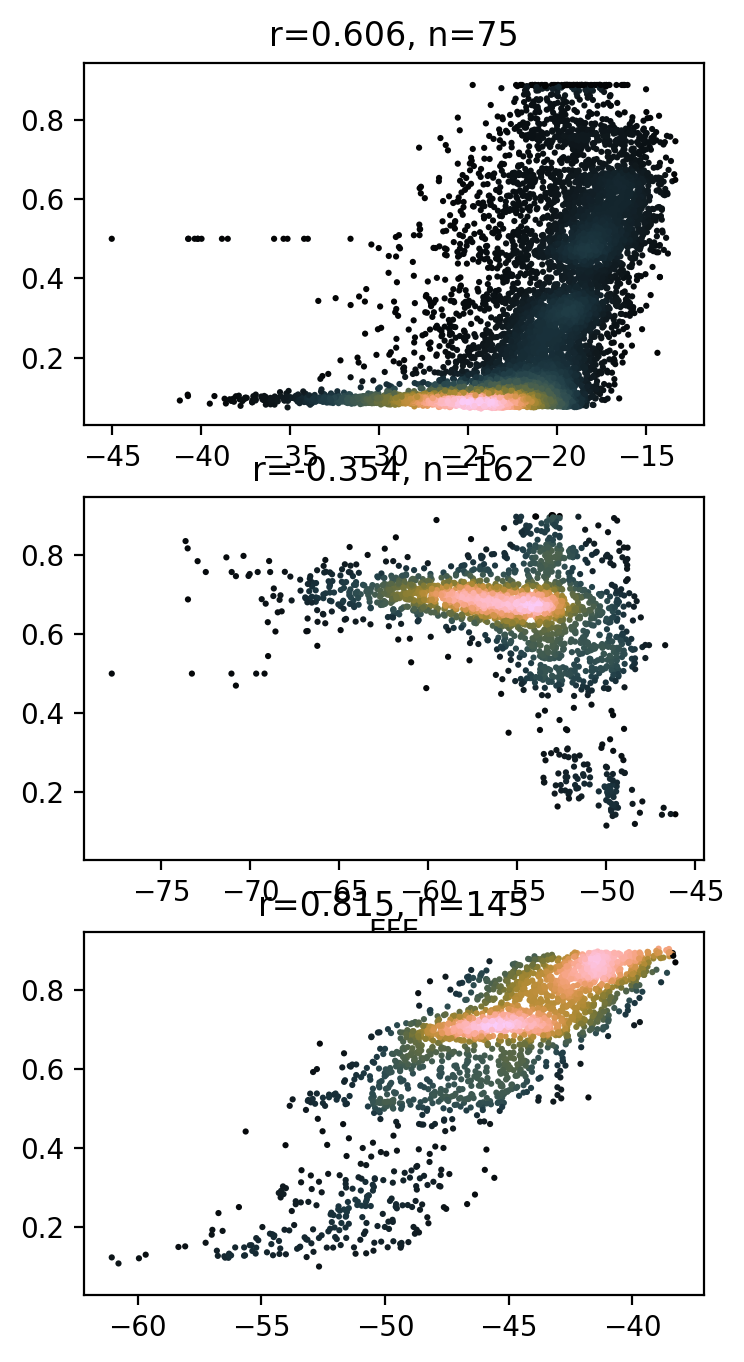

In [11]:
fig, axs = plt.subplots(3, 1, figsize=[4,8], sharey=True)

cmap_f = Colormap('batlowk').to_mpl()

dscatter_plot(efe_s5, sorts['5ss'].sort_df['mu_est'], ax=axs[0], edgecolors='none', cmap=cmap_f, rasterized=True)
axs[0].set_title(f"r={pearsonr(efe_s5, sorts['5ss'].sort_df['mu_est'])[0]:.3f}, n={bpp_s5.shape[1]}")
dscatter_plot(efe_s3, sorts['3ss'].sort_df['mu_est'], ax=axs[1], edgecolors='none', cmap=cmap_f, rasterized=True)
axs[1].set_title(f"r={pearsonr(efe_s3, sorts['3ss'].sort_df['mu_est'])[0]:.3f}, n={bpp_s3.shape[1]}")
dscatter_plot(efe_bs, sorts['bs'].sort_df['mu_est'], ax=axs[2], edgecolors='none', cmap=cmap_f, rasterized=True)
axs[2].set_title(f"r={pearsonr(efe_bs, sorts['bs'].sort_df['mu_est'])[0]:.3f}, n={bpp_bs.shape[1]}")

axs[1].set_xlabel('EFE')
plt.show()

## Figure 4d

In [12]:
e1_ha = 'UUAGUUUCGAAUAAACACACAUAAACAAACAAAUCUAGAAUGUACCCAUACGAUGUUCCUGACUAUGCUGGUUCUGCAG' # HA
e1_my = 'UUAGUUUCGAAUAAACACACAUAAACAAACAAAUCUAGAAUGGAACAAAAAUUAAUUUCUGAAGAAGAUUUAG' # Myc

bpp_ha, _, _, _, _, _, efe_ha, _, _, ed_ha = get_all_metrics([e1_ha[-w_opt[0][1][0]:] + seq[:w_opt[0][1][1]] for seq in sorts['5ss_HA'].sort_df['index']], n_cpu=8)
bpp_my, _, _, _, _, _, efe_my, _, _, ed_my = get_all_metrics([e1_my[-w_opt[0][1][0]:] + seq[:w_opt[0][1][1]] for seq in sorts['5ss_MYC'].sort_df['index']], n_cpu=8)

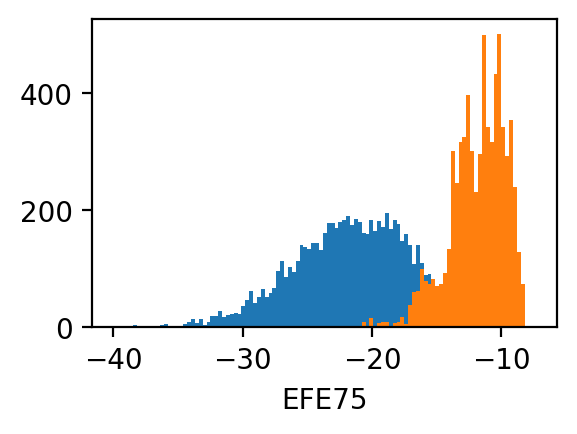

In [13]:
plt.figure(figsize=[3,2])
plt.hist(efe_ha, bins=np.arange(-40, -7, 0.3))
plt.hist(efe_my, bins=np.arange(-40, -7, 0.3))
plt.xlabel('EFE75')
plt.show()

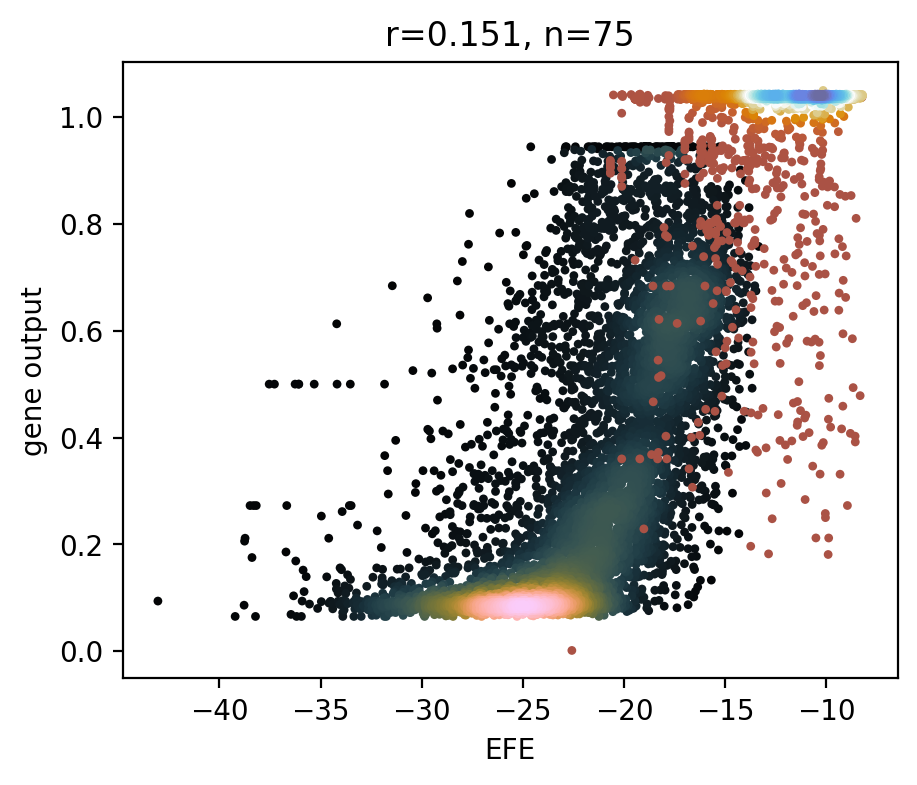

In [14]:
fig, axs = plt.subplots(figsize=[5,4])

dscatter_plot(efe_ha, sorts['5ss_HA'].sort_df['mu_est'], order=True, markersize=10, ax=axs, edgecolors='none', cmap=cmap_f, rasterized=True)
axs.set_title(f"r={pearsonr(efe_ha, sorts['5ss_HA'].sort_df['mu_est'])[0]:.3f}, n={bpp_my.shape[1]}")
axs.set_xlabel('EFE')
axs.set_ylabel('gene output')

cmap_2  = Colormap('prinsenvlag').to_mpl()
dscatter_plot(efe_my, sorts['5ss_MYC'].sort_df['mu_est'], order=True, markersize=10, ax=axs, edgecolors='none', cmap=cmap_2, rasterized=True)
axs.set_title(f"r={pearsonr(efe_my, sorts['5ss_MYC'].sort_df['mu_est'])[0]:.3f}, n={bpp_my.shape[1]}")
axs.set_xlabel('EFE')
axs.set_ylabel('gene output')
plt.show()

## Figure 4e

In [15]:
# hierarchical clustering on pairing probability matrix

a_msk = np.array([seq[6] == 'A' for seq in list(sorts['5ss'].sort_df['index'])])
criterion = 'maxclust'
method = 'ward'

clust = linkage(bpp_s5[a_msk], method=method, metric="euclidean", optimal_ordering=False)
trim = 15

# draw dendrogram, retreive class labels for two levels of trimming
labels = fcluster(clust, trim, criterion='distance')
print(len(set(labels)))

29


127
48


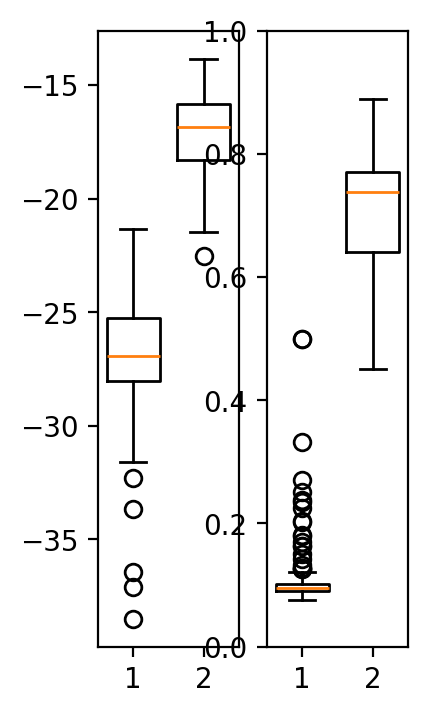

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[2, 4])

axs[0].boxplot(efe_s5[a_msk][labels==6], positions=[1], widths=0.75)
axs[0].boxplot(efe_s5[a_msk][labels==26], positions=[2], widths=0.75)

axs[1].boxplot(sorts['5ss'].sort_df['mu_est'].filter(a_msk).filter(labels==6), positions=[1], widths=0.75)
axs[1].boxplot(sorts['5ss'].sort_df['mu_est'].filter(a_msk).filter(labels==26), positions=[2], widths=0.75)
axs[1].set_ylim([0, 1])

print(np.sum(labels==6))
print(np.sum(labels==26))
plt.show()

## Figure 4f

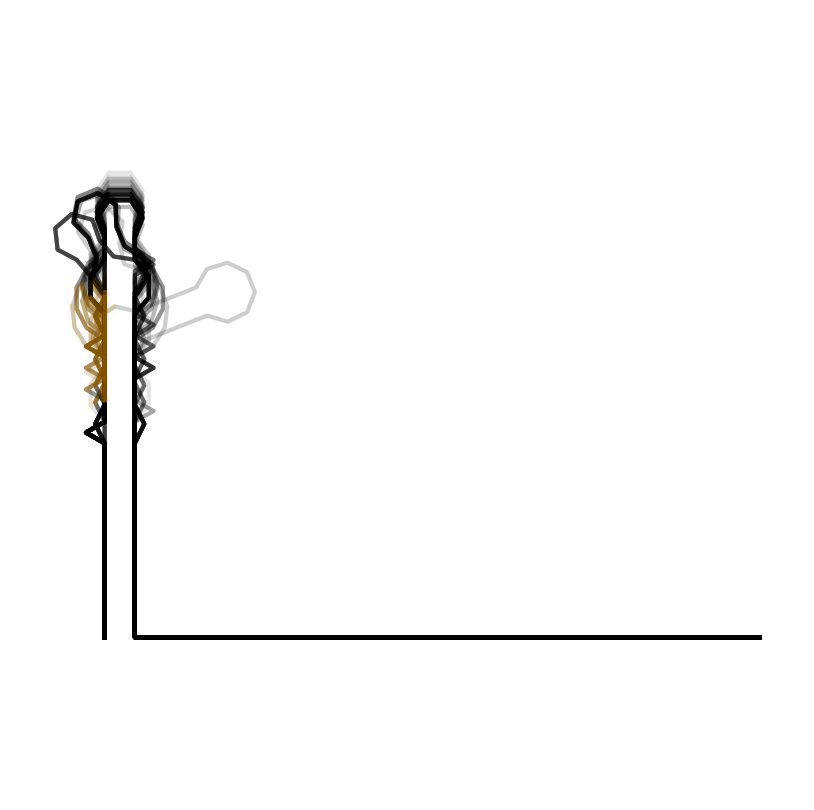

In [17]:

chosen_cluster = 6 # 26

chosen_mask = labels==chosen_cluster

fig, axs = plt.subplots(figsize=[5,5])
axs.axis('equal')
axs.axis('off')

for i in range(np.sum(chosen_mask)):

    bpp_i = bpp_s5[a_msk][chosen_mask][i]
    efe_i = efe_s5[a_msk][chosen_mask][i]
    dbr_i = dbr_s5[a_msk][chosen_mask][i]
    
    dbr_i_filt = filter_dbr_by_dist(dbr_i, 150)
    coords_x, coords_y = get_coords(dbr_i_filt)
    axs.plot(coords_x, coords_y, '-k', alpha=0.1)
    axs.plot(coords_x[12:18], coords_y[12:18], '-', color='orange', alpha=0.1)

plt.show()

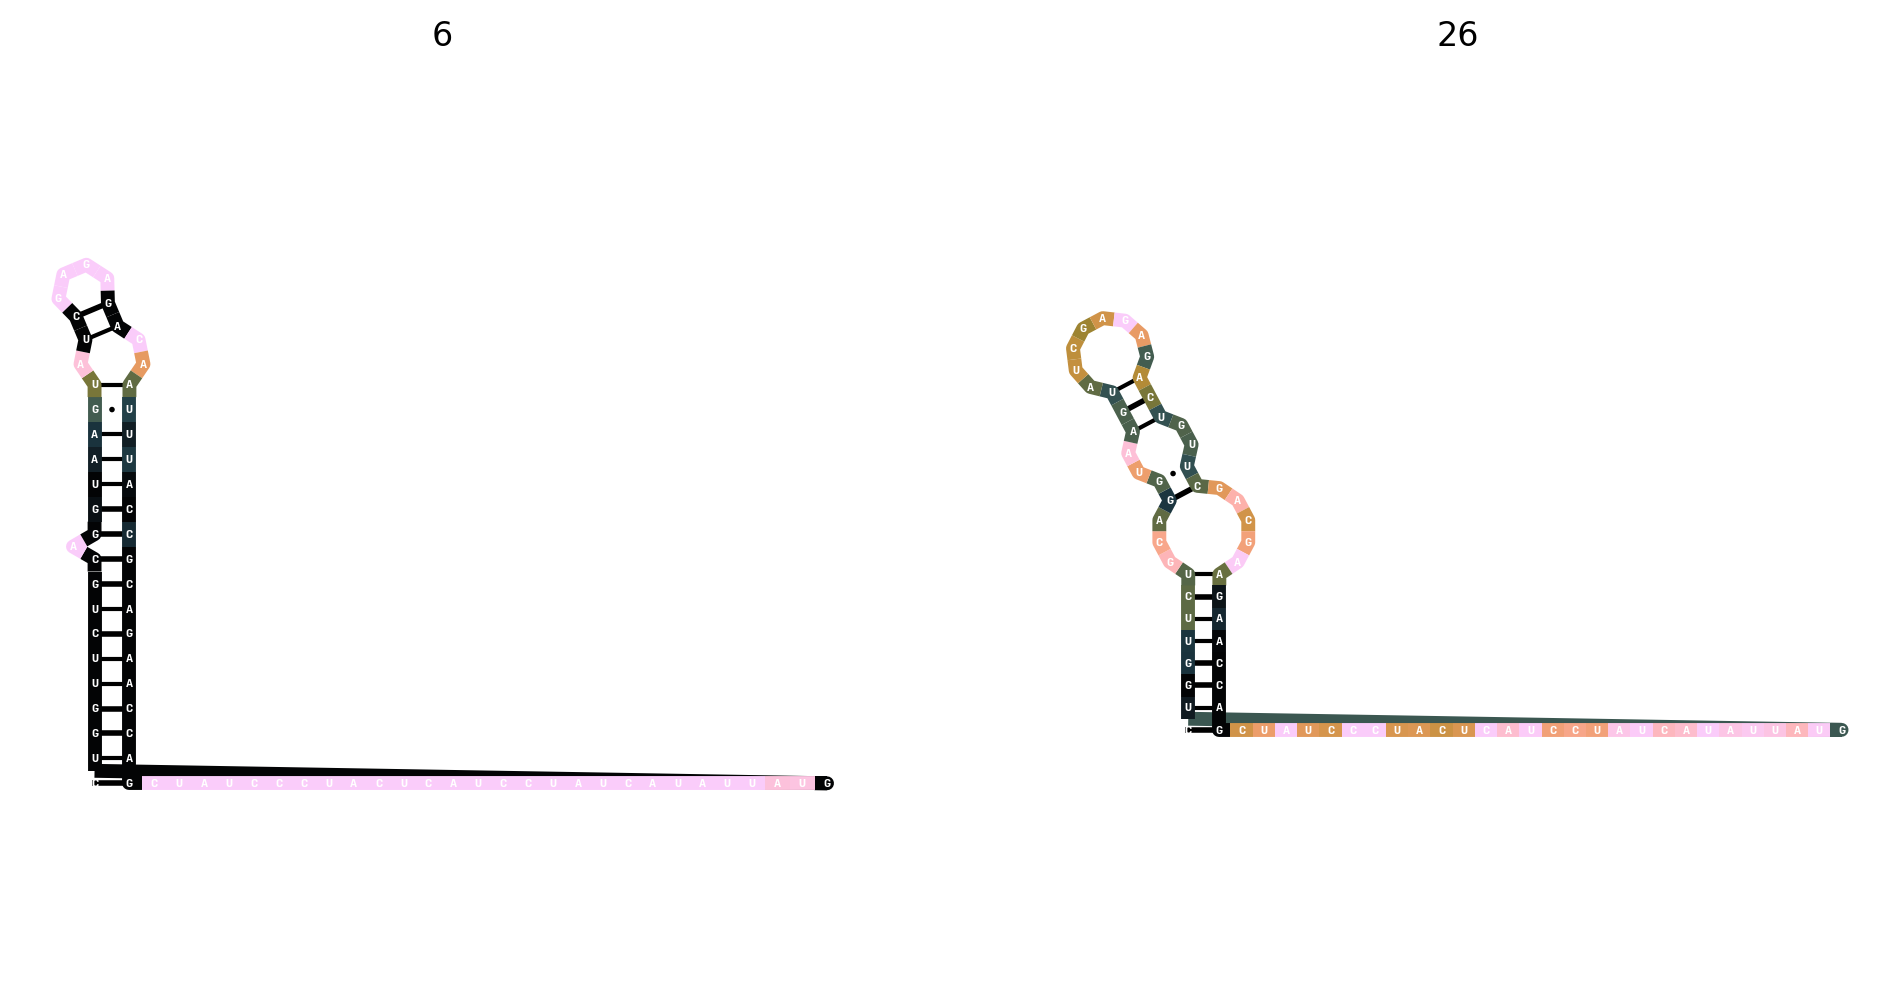

In [18]:
def score_dbr(y, dbr):
    unpaired_mask = np.array(list(dbr)) == '.'
    return(auroc(y[~unpaired_mask], y[unpaired_mask]))

def get_best_structure(avg_bpp, dbrs):
    idx_min = np.argmax([score_dbr(avg_bpp, dbr) for dbr in dbrs])
    return(idx_min)

def auroc(x, y):  
    mwu = mannwhitneyu(x, y)
    u = mwu[0]
    n1, n2 = len(x), len(y)
    area = u/(n1*n2)
    return(area)

fig, axs = plt.subplots(1, 2, figsize=[12, 6])
axs = axs.flatten()
cmap = Colormap('batlowk_r').to_mpl()
for idx, cluster_id in enumerate([6, 26]):

    avg_bpp  = np.mean(bpp_s5[a_msk][labels==cluster_id], axis=0)
    std_bpp  = np.std(bpp_s5[a_msk][labels==cluster_id], axis=0)
    idx_best = get_best_structure(avg_bpp, dbr_s5[a_msk][labels==cluster_id])
    dbr_best = dbr_s5[a_msk][labels==cluster_id][idx_best]
    dbr_best_filt = filter_dbr_by_dist(dbr_best, 150)
    
    plot_structure(np.array(p_seqs_s5)[a_msk][labels==cluster_id][idx_best], dbr_best_filt, avg_bpp, np.array([True]*len(dbr_best)), axs=axs[idx], cmap=cmap, line_width=5, text_size=4, vmin=0.1, vmax=0.9)
    axs[idx].set_title(cluster_id)

plt.show()

## Figure 4g

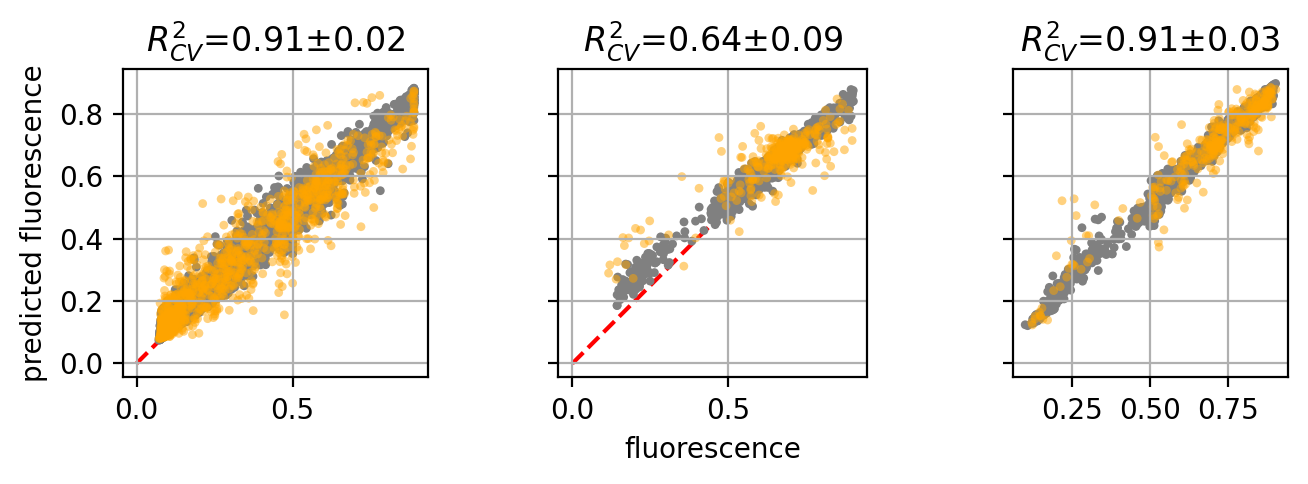

In [19]:
fig, axs = plt.subplots(1, 3, figsize=[8,2], sharey=True)

axs[0].grid(True, zorder=-100)
axs[0].plot([0, 0.8], [0, 0.8], '--r', zorder=-5)
axs[0].scatter(sorts['5ss'].sort_df['mu_est'].filter(ra_msk_s5), rfr_s5.predict(bpp_s5[ra_msk_s5]), 10, color='gray', edgecolors='none', rasterized=True)
axs[0].scatter(sorts['5ss'].sort_df['mu_est'].filter(~ra_msk_s5), rfr_s5.predict(bpp_s5[~ra_msk_s5]), 10, alpha=0.5, color='orange', edgecolors='none')
axs[0].set_title(f"$R^2_{{CV}}$={np.mean(scores_r2_s5):.2f}±{np.std(scores_r2_s5):.2f}")
axs[0].set_aspect('equal')
axs[0].set_ylabel('predicted fluorescence')

axs[1].grid(True, zorder=-100)
axs[1].plot([0, 0.8], [0, 0.8], '--r', zorder=-5)
axs[1].scatter(sorts['3ss'].sort_df['mu_est'].filter(ra_msk_s3), rfr_s3.predict(bpp_s3[ra_msk_s3]), 10, color='gray', edgecolors='none', rasterized=True)
axs[1].scatter(sorts['3ss'].sort_df['mu_est'].filter(~ra_msk_s3), rfr_s3.predict(bpp_s3[~ra_msk_s3]), 10, alpha=0.5, color='orange', edgecolors='none')
axs[1].set_title(f"$R^2_{{CV}}$={np.mean(scores_r2_s3):.2f}±{np.std(scores_r2_s3):.2f}")
axs[1].set_aspect('equal')
axs[1].set_xlabel('fluorescence')

axs[2].grid(True, zorder=-100)
axs[2].scatter(sorts['bs'].sort_df['mu_est'].filter(ra_msk_bs), rfr_bs.predict(bpp_bs[ra_msk_bs]), 10, color='gray', edgecolors='none', rasterized=True)
axs[2].scatter(sorts['bs'].sort_df['mu_est'].filter(~ra_msk_bs), rfr_bs.predict(bpp_bs[~ra_msk_bs]), 10, alpha=0.5, color='orange', edgecolors='none')
axs[2].set_title(f"$R^2_{{CV}}$={np.mean(scores_r2_bs):.2f}±{np.std(scores_r2_bs):.2f}")
axs[2].set_aspect('equal')

plt.show()

## Figure S4a

In [20]:
rfr_s5ha, scores_r2_s5ha, importance_s5ha, ra_msk_s5ha, bpp_s5ha, efe_s5ha, dbr_s5ha, p_seqs_s5ha = predict_and_train(sorts['5ss_HA'], e1_ha, w_opt[0][1][0], w_opt[0][1][1])
rfr_s5my, scores_r2_s5my, importance_s5my, ra_msk_s5my, bpp_s5my, efe_s5my, dbr_s5my, p_seqs_s5my = predict_and_train(sorts['5ss_MYC'], e1_my, w_opt[0][1][0], w_opt[0][1][1])

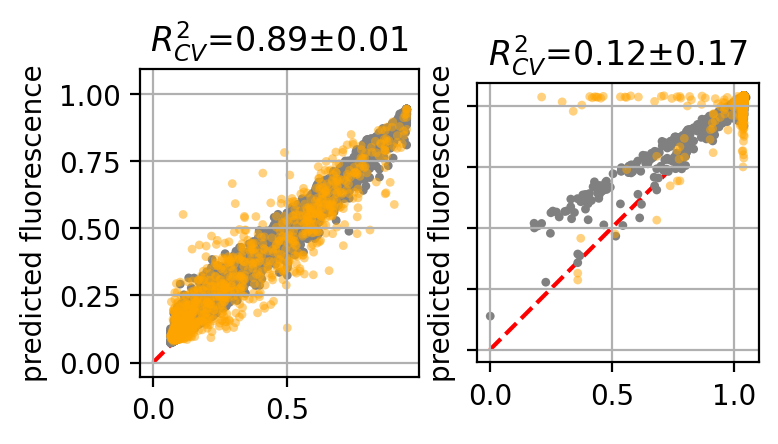

In [21]:

fig, axs = plt.subplots(1, 2, figsize=[4,2], sharey=True)

axs[0].grid(True, zorder=-100)
axs[0].plot([0, 0.8], [0, 0.8], '--r', zorder=-5)
axs[0].scatter(sorts['5ss_HA'].sort_df['mu_est'].filter(ra_msk_s5ha), rfr_s5ha.predict(bpp_s5ha[ra_msk_s5ha]), 10, color='gray', edgecolors='none', rasterized=True)
axs[0].scatter(sorts['5ss_HA'].sort_df['mu_est'].filter(~ra_msk_s5ha), rfr_s5ha.predict(bpp_s5ha[~ra_msk_s5ha]), 10, alpha=0.5, color='orange', edgecolors='none')
axs[0].set_title(f"$R^2_{{CV}}$={np.mean(scores_r2_s5ha):.2f}±{np.std(scores_r2_s5ha):.2f}")
axs[0].set_aspect('equal')
axs[0].set_ylabel('predicted fluorescence')

axs[1].grid(True, zorder=-100)
axs[1].plot([0, 0.8], [0, 0.8], '--r', zorder=-5)
axs[1].scatter(sorts['5ss_MYC'].sort_df['mu_est'].filter(ra_msk_s5my), rfr_s5my.predict(bpp_s5my[ra_msk_s5my]), 10, color='gray', edgecolors='none', rasterized=True)
axs[1].scatter(sorts['5ss_MYC'].sort_df['mu_est'].filter(~ra_msk_s5my), rfr_s5my.predict(bpp_s5my[~ra_msk_s5my]), 10, alpha=0.5, color='orange', edgecolors='none')
axs[1].set_title(f"$R^2_{{CV}}$={np.mean(scores_r2_s5my):.2f}±{np.std(scores_r2_s5my):.2f}")
axs[1].set_aspect('equal')
axs[1].set_ylabel('predicted fluorescence')

plt.show()

## Figure S4b

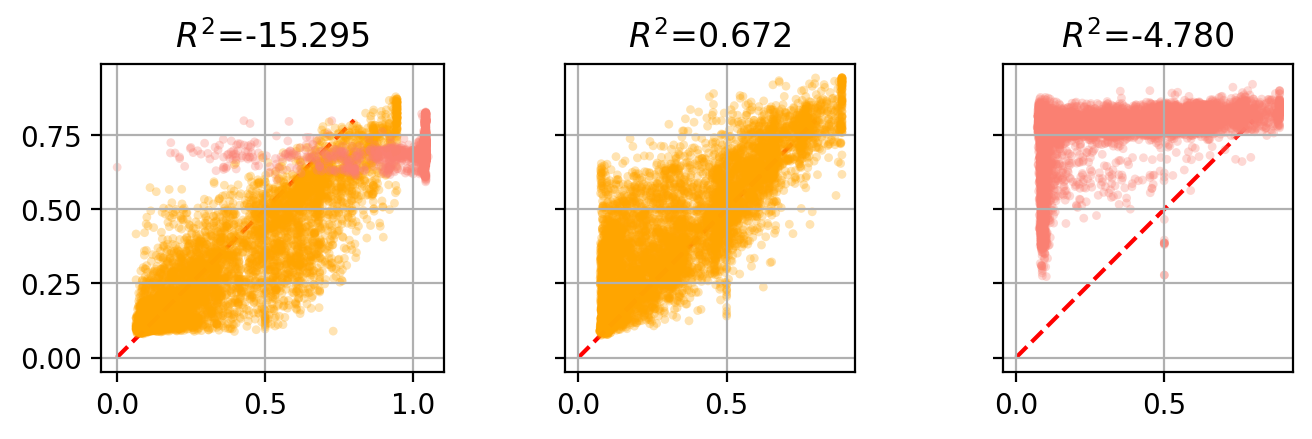

In [22]:
# Can model trained with data from one expt predict data from separate expt?
fig, axs = plt.subplots(1, 3, figsize=[8,2], sharey=True)

axs[0].grid(True, zorder=-100)
axs[0].plot([0, 0.8], [0, 0.8], '--r', zorder=-5)
axs[0].scatter(sorts['5ss_HA'].sort_df['mu_est'], rfr_s5.predict(bpp_ha), 10, color='orange', alpha=0.3, edgecolors='none', rasterized=True)
axs[0].scatter(sorts['5ss_MYC'].sort_df['mu_est'], rfr_s5.predict(bpp_my), 10, color='salmon', alpha=0.3, edgecolors='none', rasterized=True)
axs[0].set_title(f"$R^2$={r2_score(sorts['5ss_MYC'].sort_df['mu_est'], rfr_s5.predict(bpp_my)):.3f}")
axs[0].set_aspect('equal')

axs[1].grid(True, zorder=-100)
axs[1].plot([0, 0.8], [0, 0.8], '--r', zorder=-5)
axs[1].scatter(sorts['5ss'].sort_df['mu_est'], rfr_s5ha.predict(bpp_s5), 10, color='orange', alpha=0.3, edgecolors='none', rasterized=True)
axs[1].set_title(f"$R^2$={r2_score(sorts['5ss'].sort_df['mu_est'], rfr_s5ha.predict(bpp_s5)):.3f}")
axs[1].set_aspect('equal')

axs[2].grid(True, zorder=-100)
axs[2].plot([0, 0.8], [0, 0.8], '--r', zorder=-5)
axs[2].scatter(sorts['5ss'].sort_df['mu_est'], rfr_s5my.predict(bpp_s5), 10, color='salmon', alpha=0.3, edgecolors='none', rasterized=True)
axs[2].set_title(f"$R^2$={r2_score(sorts['5ss'].sort_df['mu_est'], rfr_s5my.predict(bpp_s5)):.3f}")
axs[2].set_aspect('equal')

plt.show()

## Figure 4h

In [23]:
# set variable sequence region
variable_seqs = {'5ss': (6,26),
                 '3ss': (69,89),
                 'bs': (44,72)}

efes = {'5ss': efe_s5,
        '3ss': efe_s3,
        'bs':  efe_bs}

In [24]:
import pandas as pd

# change here depending on which library you want to run through MAVE-NN
# lib = '5ss'
# lib = '3ss'
lib = 'bs'

# prepare data for MAVE-NN
data_df = pd.DataFrame({'x': [i[variable_seqs[lib][0]:variable_seqs[lib][1]].replace('T', 'U') for i in list(sorts[lib].sort_df['index'])], 
                        'y': sorts[lib].sort_df['mu_est'], 
                        'dy': sorts[lib].sort_df['si_est']}).reset_index()

# Get and report sequence length
L = len(data_df.loc[0,'x'])
print(f'Sequence length: {L:d} RNA nucleotides')

# Assign data to training, validation, or test sets
data_df['set'] = np.random.choice(a=['training', 'validation', 'test'],
                                   p=[.8,.1,.1],
                                   size=len(data_df))

trainval_df, test_df = mavenn.split_dataset(data_df)

Sequence length: 28 RNA nucleotides
Training set   :    1,660 observations (  81.05%)
Validation set :      197 observations (   9.62%)
Test set       :      191 observations (   9.33%)
-------------------------------------------------
Total dataset  :    2,048 observations ( 100.00%)



In [25]:
# Set default keyword arguments for model.Model()
default_model_kwargs = {
    'L':L,
    'alphabet':'rna',
    'regression_type':'GE',
    'ge_noise_model_type':'Gaussian', # 'Gaussian', 'Cauchy', 'SkewedT', or 'Empirical'
    'ge_heteroskedasticity_order': 0,
    'gpmap_kwargs': {'hidden_layer_sizes':[10]*5, 'features':'pairwise'},
}

# Set default keyword arguments for model.fit()
default_fit_kwargs = {
    'learning_rate':.0005,
    'epochs':700,
    'batch_size':50,
    'early_stopping':False,
    'early_stopping_patience':100,
    'linear_initialization':False,
    'verbose':False,
}

# Instantiate model using the keyword arguments in model_kwargs dict
model = mavenn.Model(gpmap_type='pairwise', **default_model_kwargs)

# Set training data
model.set_data(x=trainval_df['x'],
               y=trainval_df['y'],
               dy=trainval_df['dy'],
               validation_flags=trainval_df['validation'])

# Train model using the keyword arguments in fig_kwargs dict
model.fit(**default_fit_kwargs)

N = 1,857 observations set as training data.
Using 10.6% for validation.
Data shuffled.
Time to set data: 0.0244 sec.


0epoch [00:00, ?epoch/s]

Training time: 87.1 seconds


test_I_var: 1.086 +- 0.216 bits
test_I_pred: 1.515 +- 0.070 bits


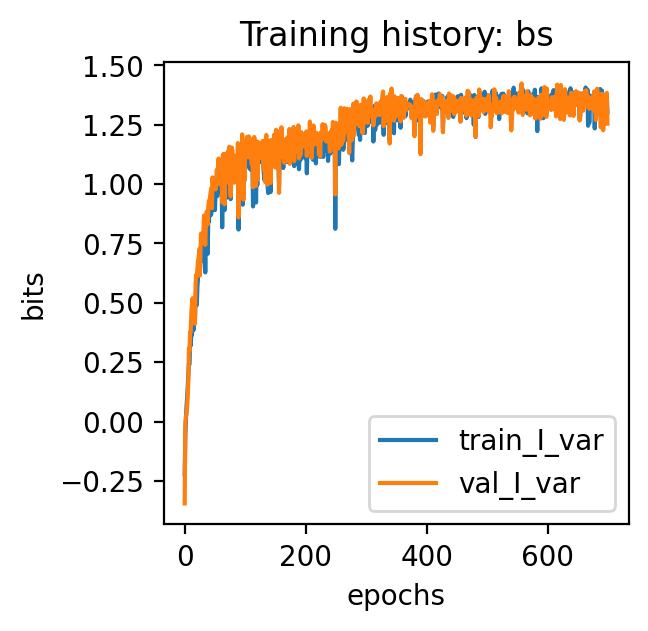

In [26]:
# Compute variational information on test data
I_var, dI_var =  model.I_variational(x=test_df['x'], y=test_df['y'])
print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Create figure and axes for plotting
fig, axs = plt.subplots(figsize=[3,3])

# Plot I_var_train, the variational information on training data as a function of epoch
axs.plot(model.history['I_var'], label=r'train_I_var')

# Plot I_var_val, the variational information on validation data as a function of epoch
axs.plot(model.history['val_I_var'], label=r'val_I_var')

# Style plot
axs.set_xlabel('epochs')
axs.set_ylabel('bits')
axs.set_title(f'Training history: {lib}')
axs.legend()
plt.show()

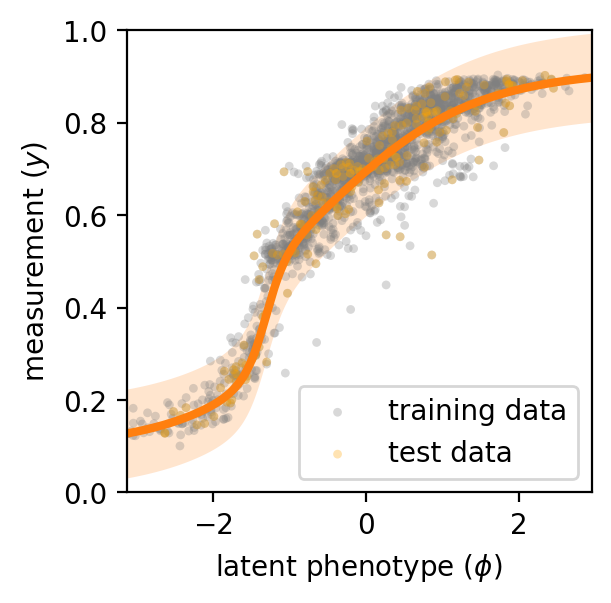

In [27]:
# Create figure and axes for plotting
fig, axs = plt.subplots(figsize=[3, 3])

# Get test data y values
y_test = test_df['y']

# Compute phi on test data
phi_test = model.x_to_phi(test_df['x'])
phi_all  = model.x_to_phi(data_df['x'])

## Set phi lims and create a grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat for each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 95% CI for each yhat
q = [0.025, 0.975]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Plote 95% confidence interval
axs.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1], alpha=0.2, color='C1', lw=0)

# Plot GE nonlinearity
axs.plot(phi_grid, yhat_grid, linewidth=3, color='C1')

# Plot scatter of phi and y values.
axs.scatter(phi_all, data_df['y'], color='gray', s=10, alpha=.3, label='training data', edgecolors='none')
axs.scatter(phi_test, test_df['y'], color='orange', s=10, alpha=.3, label='test data', edgecolors='none')

axs.set_xlim(phi_lim)
axs.set_xlabel('latent phenotype ($\phi$)')
axs.set_ylabel('measurement ($y$)')
axs.set_ylim([0,1])
axs.legend()
plt.show()

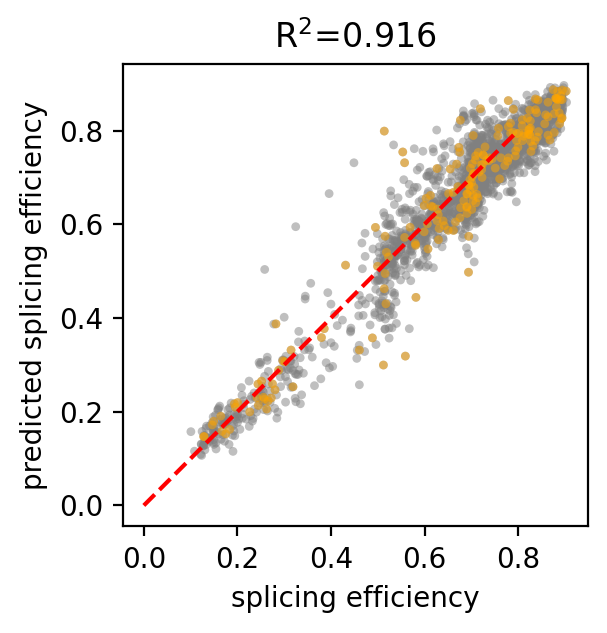

In [28]:
fig, axs = plt.subplots(figsize=[3,3])

axs.plot([0, 0.8], [0, 0.8], '--r')
axs.scatter(data_df['y'], model.x_to_yhat(data_df['x']), 10, 'gray', alpha=0.5, edgecolors='none')
axs.scatter(test_df['y'], model.x_to_yhat(test_df['x']), 10, 'orange', alpha=0.5, edgecolors='none')
axs.set_aspect('equal')
axs.set_ylabel('predicted splicing efficiency')
axs.set_xlabel('splicing efficiency')
axs.set_title(f"R$^2$={r2_score(test_df['y'], model.x_to_yhat(test_df['x'])):.3f}")
axs.axis('equal')

plt.show()

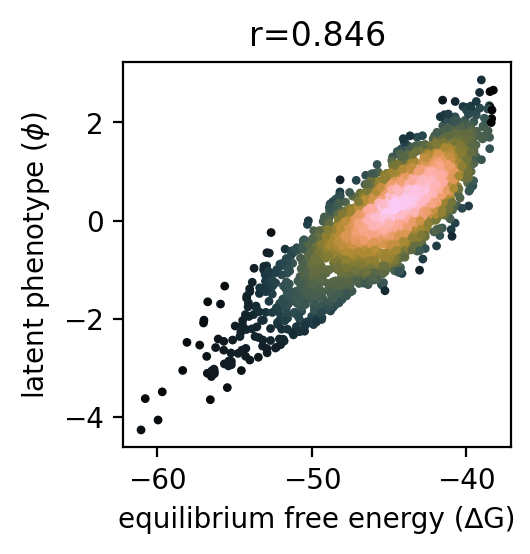

In [29]:
fig, axs = plt.subplots(figsize=[2.5,2.5])

cmap = Colormap('batlowk').to_mpl()
dscatter_plot(efes[lib], model.x_to_phi(data_df['x']), nbins=[100,100], markersize=10, cmap=cmap, alpha=1, edgecolors='none', ax=axs)
axs.set_ylabel('latent phenotype ($\phi$)')
axs.set_xlabel('equilibrium free energy (∆G)')
axs.set_title(f"r={pearsonr(efes[lib], model.x_to_phi(data_df['x']))[0]:.3f}")

plt.show()